# Developing `load_era5()` function from Google

Guidance from https://github.com/google-research/arco-era5/blob/main/docs/0-Surface-Reanalysis-Walkthrough.ipynb

In [1]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from datacube.utils.geometry import assign_crs

## Load reanalysis

In [2]:
def lon_to_360(dlon: float) -> float:
    return ((360 + (dlon % 360)) % 360)

def load_era5_g(
    var, lat, lon, time,
    reduce_func=None,
    resample="1D",
):
    """
    Download and return an ERA5 variable for a defined time window.

    Parameters
    ----------
    var : string
        Name of the ERA5 climate variable to download, e.g "air_temperature_at_2_metres"

    lat: tuple or list
        Latitude range for query.

    lon: tuple or list
        Longitude range for query.

    time: string or datetime object or a list or tuple of strings or datetime objects
        Used to define starting and end date dates of the time window.

    reduce_func: numpy function
        lets you specify a function to apply to each day's worth of data.
        The default is np.mean, which computes daily average. To get a sum, use np.sum.

    resample: string
        Temporal resampling frequency to be used for xarray's resample function.
        The default is '1D', which is daily.
        Since this is applied on monthly ERA5 data, maximum resampling period is '1M'.

    Returns
    -------
    A lazy-loaded xarray dataset containing an ERA5 variable for the selected region and time window.

    """
    
#   constrain query to available variables
    ERA5_VARS = ['air_pressure_at_mean_sea_level',
                 'air_temperature_at_2_metres',
                 'dew_point_temperature_at_2_metres',
                 'eastward_wind_at_100_metres',
                 'eastward_wind_at_10_metres',
                 'northward_wind_at_100_metres',
                 'northward_wind_at_10_metres',
                 'precipitation_amount_1hour_Accumulation',
                 'sea_surface_temperature',
                 'surface_air_pressure']

    assert var in ERA5_VARS, "var must be one of [{}] (got {})".format(
        ",".join(ERA5_VARS), var
    )
    
    # process date range
    if type(time) in [list, tuple]:
        date_from = np.datetime64(min(time)).astype('datetime64[D]')
        date_to = (np.datetime64(max(time))+1).astype('datetime64[D]')-np.timedelta64(1,'D')
    elif type(time) in [str, np.datetime64]:
        date_from = np.datetime64(time).astype('datetime64[D]')
        date_to = (np.datetime64(time)+1).astype('datetime64[D]')-np.timedelta64(1,'D')
    else:
        raise(ValueError)

    ERA5_dict = {'air_pressure_at_mean_sea_level':'msl',
                 'air_temperature_at_2_metres':'t2m',
                 'dew_point_temperature_at_2_metres':'2d',
                 'eastward_wind_at_100_metres':'100u',
                 'eastward_wind_at_10_metres':'10u',
                 'northward_wind_at_100_metres':'100v',
                 'northward_wind_at_10_metres':'10v',
                 'precipitation_amount_1hour_Accumulation':'tp',
                 'sea_surface_temperature':'sst',
                 'surface_air_pressure':'sp',
                 'skin temperature':'skt'}
    

    if ERA5_dict[var] == 'tp':
        url = 'gs://gcp-public-data-arco-era5/co/single-level-forecast.zarr-v2'
    else:
        url = 'gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr-v2'

    if reduce_func is None:
            reduce_func = np.mean
    ds = xr.open_zarr(
        url, 
        chunks={'time': 48},
        consolidated=True).sel(time=slice(date_from, date_to))[[ERA5_dict[var]]].compute()
            
    ds = ds.where(
        (ds.longitude > lon_to_360(lon[0])) & (ds.latitude > lat[0]) &
        (ds.longitude < lon_to_360(lon[1])) & (ds.latitude < lat[1]),
        drop=True
        )
        
    if ERA5_dict[var] == 'tp':
        ds = ds.resample(step=resample).reduce(reduce_func)
        ds = ds.resample(time=resample).reduce(reduce_func)
    else:
        ds = ds.resample(time=resample).reduce(reduce_func)
        
        ds =  (ds.
           to_dataframe().
           droplevel(1).
           reset_index().
           set_index(['time','latitude','longitude']).
           to_xarray())
    
        ds = ds.rename({'latitude':'lat','longitude': 'lon', ERA5_dict[var]: var}).drop_vars(['depthBelowLandLayer', 'entireAtmosphere', 'number', 'step', 'surface'])
        
        return assign_crs(ds, 'EPSG:4326')

In [3]:
lat = (-37, -10.7)
lon = (2, 53.1)

time = '2021-01', '2021-03'

In [4]:
var = 'air_temperature_at_2_metres'

airtemp = load_era5_g(var, lat, lon, time, reduce_func=np.nanmean).compute()

airtemp

/usr/local/lib/python3.10/dist-packages/xarray/core/dataset.py:265: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 48. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset>
Dimensions:                      (time: 90, lat: 94, lon: 908)
Coordinates:
  * time                         (time) datetime64[ns] 2021-01-01 ... 2021-03-31
  * lat                          (lat) float64 -36.96 -36.67 ... -11.1 -10.82
  * lon                          (lon) float64 2.074 2.1 2.188 ... 53.04 53.1
    spatial_ref                  int32 4326
Data variables:
    air_temperature_at_2_metres  (time, lat, lon) float32 nan nan ... nan nan
Attributes:
    grid_mapping:  spatial_ref

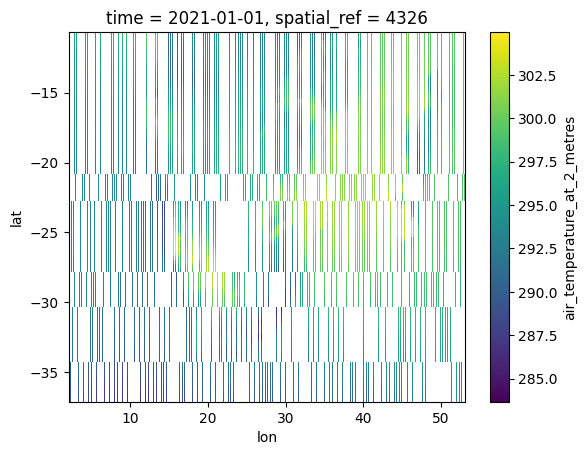

In [5]:
airtemp.air_temperature_at_2_metres[0].plot()

## Next steps

1. Assign spatial dimensions and crs to xarray dataset
2. Wrap up in `load_era5()` function.